# Máster en Big Data Science - UNAV 
-----------------------------------------------------------------------------------------------------------------------------------------
### Deep Learning - Entrega 2
### María Auxiliadora Solano Ramírez - Junio 2022

# Text Classification model
- Tutorial: https://www.tensorflow.org/text/tutorials/text_classification_rnn
- Database: https://www.kaggle.com/datasets/kazanova/sentiment140
- Objetivo: Predict possitive and negative tweets

## 1. Setup
Importing dependencies, the principal required libraries

In [4]:
#data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#Neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 2. Data exploration
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .
### 2.1 General exploration

In [5]:
dataframe = pd.read_csv('training.1600000.processed.noemoticon.csv',header=None,encoding='latin-1')
dataframe = dataframe.set_axis(['target','ids','date','flag','user','text'], axis=1)
dataframe.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


**Conclusion:** Dataset with 1600000 lines is too big, so the initial modeling will be experimentary with a 10% sample

In [7]:
#DataFrame random reduction
print(dataframe.shape)
dataframe = dataframe.sample(frac=0.1,random_state=1)
print(dataframe.shape)

(1600000, 6)
(160000, 6)


In [8]:
#Reduce dataframe to feature and target
dataframe = dataframe[['target','text']]
dataframe.head()

,target,text
514293,0,i miss nikki nu nu already shes always there ...
142282,0,So I had a dream last night. I remember a sig...
403727,0,@girlyghost ohh poor sickly you (((hugs)) ho...
649503,0,it is raining again
610789,0,@MissKeriBaby wish I was in LA right now


### 2.2 Target Value
The column "target" describe the tweet is negative (target=0) or possitive (target=4). It is the value we are trying to predict

In [9]:
#Check the count between classifications
values = dataframe.target.value_counts()
percent = dataframe.target.value_counts()/len(dataframe)*100

#output: target is in balance
table = pd.DataFrame(values)
table['Percent'] = percent
table =table.rename(columns={'target':"Count"})
table

,Count,Percent
4,80164,50.1025
0,79836,49.8975


**Conclusion:** Target data column is in balance, 50% each category

## 3. Prepare dataset
### 3.1 Train-Validation-Test Split
The dataset is divided in 3 sections for training, validation and testing. This datasets will be used to train the model and test against it.

In [10]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(dataframe, test_size=0.3,random_state=1)
print("test_shape:" + str(test_df.shape))

#Split in train set and validation set
train_df, val_df = train_test_split(train_df, test_size=0.3)
print("validation_shape:" + str(val_df.shape))
print("train_shape:" + str(train_df.shape))

test_shape:(48000, 2)
validation_shape:(33600, 2)
train_shape:(78400, 2)


**Text:** Defined as feature data

In [11]:
#Check text column count in train
X_train = train_df.text
X_train.shape

(78400,)

In [12]:
#Check text column count in validation
X_val = val_df.text
X_val.shape

(33600,)

In [13]:
#Check text column count in test
X_test = test_df.text
X_test.shape

(48000,)

**Target:** Defined as target data

In [14]:
#Check target column count in train
y_train = train_df.target
y_train.value_counts()

4    39337
0    39063
Name: target, dtype: int64

In [15]:
#Check target column count in validation
y_val = val_df.target
y_val.value_counts()

0    16863
4    16737
Name: target, dtype: int64

In [16]:
#Check target column count in test
y_test = test_df.target
y_test.value_counts()

4    24090
0    23910
Name: target, dtype: int64

### 3.2 Transformation
**Text**

Text encoder. A preprocessing layer that maps text features and transforms them to integer sequences according to a dictionary based on the dataset

In [17]:
#Vocabulary and ecoder definition
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(X_train.values)

In [18]:
#TensorFlow object 
encoder

In [19]:
#check if data is already adapted
encoder.is_adapted

True

In [20]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'to', 'the', 'a', 'my', 'and', 'you', 'is', 'it',
       'for', 'in', 'of', 'im', 'on', 'me', 'so', 'have', 'that'],
      dtype='<U13')

In [21]:
#Example
print("\033[1m"+"Real text:"+"\033[0m")
print(train_df.text[:3])

encoded_example = encoder(train_df.text)[:3].numpy()

print("\n"+"\033[1m"+"Vocabulary detected:"+"\033[0m")
for n in range(3):
    print(vocab[encoded_example[n]])

print("\n"+"\033[1m"+"Encoded text:"+"\033[0m")
print(encoded_example)

Real text:
245880         i gotta go!  my parents r the RUDEST ppl EVER
1524484    @arismckayl hey you! Are you still on? Anyway,...
1536782                     @YoursTrulyXXOO thanks so much! 
Name: text, dtype: object

Vocabulary detected:
['i' 'gotta' 'go' 'my' 'parents' 'r' 'the' '[UNK]' 'ppl' 'ever' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
['[UNK]' 'hey' 'you' 'are' 'you' 'still' 'on' 'anyway' 'did' 'you' 'get'
 'my' 'reply' 'no' 'one' 'in' '[UNK]' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '']
['[UNK]' 'thanks' 'so' 'much' '' '' '' '' '' '' '' '' '' '' '' '' '' '' ''
 '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']

Encoded text:
[[  2 283  38   6 716 388   4   1 656 210   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 152   8  36   8  68  15 587 118   8  33   6 554  39  57  12   1   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1  77  17  84   

**Target**

Rename the positive tweet changing target=4 to 1

In [22]:
#train
y_train = y_train.replace(4,1)
print(y_train.unique())

#validation
y_val = y_val.replace(4,1)
print(y_val.unique())

#test
y_test = y_test.replace(4,1)
print(y_test.unique())

[0 1]
[1 0]
[0 1]


In [23]:
#replace positive to 1
#train set
train_df['target'] = train_df.target.replace(4,1)
print("Train")
print(train_df.head())

#Validation set
val_df['target'] = val_df.target.replace(4,1)
print("Validation")
print(val_df.head())

#Test set
test_df['target'] = test_df.target.replace(4,1)
print("Test")
print(test_df.head())

Train
         target                                               text
245880        0      i gotta go!  my parents r the RUDEST ppl EVER
1524484       1  @arismckayl hey you! Are you still on? Anyway,...
1536782       1                   @YoursTrulyXXOO thanks so much! 
1044203       1  Last Chemistry lesson for this school year!  O...
162501        0                                          Headache 
Validation
         target                                               text
1311854       1  Ummmm. Who invented profanity? Why is bitch a ...
425618        0  @IlanBr  Not yet.  Need more traffic on the ol...
55580         0                 Bored @ the condo! Nobody is home 
1541986       1  @ddlovato i've voted for you!  Demi say me Goo...
783661        0  @glennmarsalim come to think of it, all my awa...
Test
         target                                               text
702516        0                       @MindHeartSpirit i feel you 
555376        0  @Dublins98Dave Seen loa

C:\Users\auxis\AppData\Local\Temp\ipykernel_5940\4180812459.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['target'] = test_df.target.replace(4,1)


## 4. Model

Check how work encoder inside a model

In [24]:
# Create the model that uses the vectorize text layer
model = tf.keras.models.Sequential()

# Start by creating an explicit input layer. It needs to have a shape of
# (1,) (because we need to guarantee that there is exactly one string
# input per batch), and the dtype needs to be 'string'.
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# The first layer in our model is the vectorization layer. After this
# layer, we have a tensor of shape (batch_size, max_len) containing vocab
# indices.
model.add(encoder)


In [25]:
# Now, the model can map strings to integers, and you can add an embedding
# layer to map these integers to learned embeddings.
input_data = [["foo qux that bar"], ["qux good baz"]]
model.predict(input_data) #it show the index in vocabulary list

array([[ 1,  1, 19,  1],
       [ 1, 31,  1,  0]], dtype=int64)

### 4.1 Model 1
#### Make the model

In [26]:
model = Sequential()

#Pre-processing
#encoder: prepare the input 
model.add(encoder)
#embedding: Turns positive integers (indexes) into dense vectors of fixed size.
model.add(layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True))

#Corpus
#Bidirectional layer: This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
model.add(layers.Bidirectional(tf.keras.layers.LSTM(64)))
# Dense layer: Densely-connected NN layer
model.add(layers.Dense(64, activation='relu'))

#Final layer: a single output from binary target
model.add(layers.Dense(1, activation='sigmoid'))

In [27]:
# predict on a sample text without padding.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.5012491]


In [28]:
# predict on a sample text with padding
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.5012491]


**Conclusion:** 
The model is not training, that's why the predictions are the same in both cases

In [29]:
#compile: Configures the model for training
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), #BinaryCrossentropy: binary target
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

#### Training

In [30]:
#Trains the model for a fixed number of epochs (iterations on a dataset).
history = model.fit(x=train_df.text, y=train_df.target,
                    epochs=10,
                    batch_size=500,
                    validation_data=(val_df.text,val_df.target),
                    validation_steps=10)

Epoch 1/10
157/157 [==============================] - 61s 278ms/step - loss: 0.5404 - accuracy: 0.7243 - val_loss: 0.4998 - val_accuracy: 0.7572
Epoch 2/10
157/157 [==============================] - 39s 249ms/step - loss: 0.4796 - accuracy: 0.7673 - val_loss: 0.4973 - val_accuracy: 0.7566
Epoch 3/10
157/157 [==============================] - 38s 245ms/step - loss: 0.4705 - accuracy: 0.7729 - val_loss: 0.4923 - val_accuracy: 0.7610
Epoch 4/10
157/157 [==============================] - 36s 231ms/step - loss: 0.4609 - accuracy: 0.7762 - val_loss: 0.4896 - val_accuracy: 0.7612
Epoch 5/10
157/157 [==============================] - 38s 244ms/step - loss: 0.4524 - accuracy: 0.7814 - val_loss: 0.4893 - val_accuracy: 0.7650
Epoch 6/10
157/157 [==============================] - 38s 245ms/step - loss: 0.4451 - accuracy: 0.7854 - val_loss: 0.4857 - val_accuracy: 0.7680
Epoch 7/10
157/157 [==============================] - 39s 246ms/step - loss: 0.4389 - accuracy: 0.7890 - val_loss: 0.4909 - val_ac

In [32]:
#history plot function
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

(0.0, 1.0)

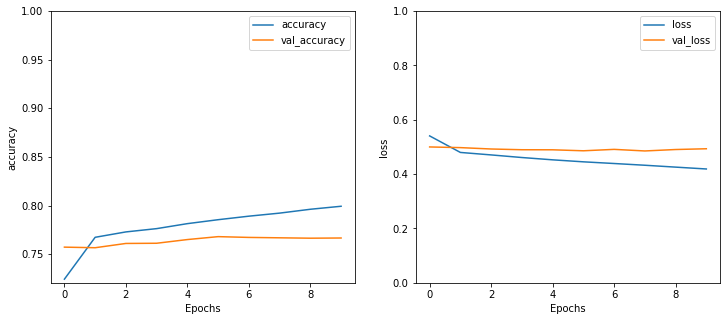

In [33]:
#Check the evolution in accuracy and loss around the epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, 1)

**Conclusion:** Validation loss is not learning well
- Accuracy is going better in training than in validation
- Loss function is very slow

#### Testing

In [31]:
#testing
test_loss, test_acc = model.evaluate(test_df.text,test_df.target)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1500/1500 [==============================] - 22s 12ms/step - loss: 0.4908 - accuracy: 0.7658
Test Loss: 0.4907582700252533
Test Accuracy: 0.7657708525657654


In [34]:
#Example to predict with the fitted model
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[0.9694481]], dtype=float32)

**Conclusion:** The model is training, the prediction is not the same in both cases

#### Metrics

In [35]:
#Prediction
pred1 = model.predict(test_df.text)
pred1

array([[0.22623155],
       [0.713588  ],
       [0.01222339],
       ...,
       [0.8136341 ],
       [0.07353884],
       [0.86706424]], dtype=float32)

In [36]:
#Confusion matrix viualization 
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(test_df.target, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0], (cm[0][0]/(cm[0][0]+cm[1][0]))*100,"%")
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1], (cm[1][1]/(cm[1][1]+cm[0][1]))*100,"%")
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Legitimate Transactions Detected (True Negatives):  17562 78.20278754953912 %
Legitimate Transactions Incorrectly Detected (False Positives):  6348
Fraudulent Transactions Missed (False Negatives):  4895
Fraudulent Transactions Detected (True Positives):  19195 75.14779000117449 %
Total Fraudulent Transactions:  24090


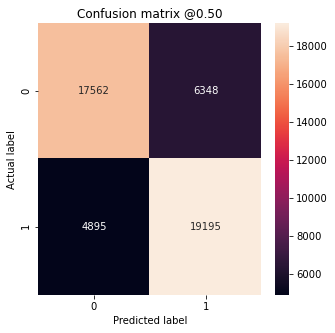

In [37]:
#Metrics
plot_cm(test_df.target, pred1)

**Model 1 conclusions:**
- Model 1 is overfitting
- Validation Accuracy is not improving if we increase epochs, but Training Accuracy does improvement   
- Training Loss function is better than Validation Loss Function
- The testing accuracy could be better

### 4.2 Model 2
#### Make the model

In [38]:
model2 = Sequential()

#Pre-processing
#encoder: prepare the input 
model2.add(encoder)
#embedding: Turns positive integers (indexes) into dense vectors of fixed size.
model2.add(layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True))

#Corpus
#Bidirectional layer: This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
model2.add(layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)))
model2.add(layers.Bidirectional(tf.keras.layers.LSTM(32)))
# Dense layer: Densely-connected NN layer
model2.add(layers.Dense(64, activation='relu'))
#Applies Dropout for regularization
model2.add(layers.Dropout(0.5))

#Final layer: a single output from binary target
model2.add(layers.Dense(1, activation='sigmoid'))

In [39]:
model2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                      

#### Training

In [40]:
history2 = model2.fit(x=train_df.text, y=train_df.target,
                     epochs=10,
                     batch_size=1000,
                     validation_data=(val_df.text,val_df.target),
                     validation_steps=30)

Epoch 1/10
79/79 [==============================] - 100s 913ms/step - loss: 0.6880 - accuracy: 0.6009 - val_loss: 0.6758 - val_accuracy: 0.6439
Epoch 2/10
79/79 [==============================] - 70s 887ms/step - loss: 0.6294 - accuracy: 0.6872 - val_loss: 0.5806 - val_accuracy: 0.7261
Epoch 3/10
79/79 [==============================] - 76s 958ms/step - loss: 0.5555 - accuracy: 0.7485 - val_loss: 0.5392 - val_accuracy: 0.7554
Epoch 4/10
79/79 [==============================] - 74s 934ms/step - loss: 0.5262 - accuracy: 0.7632 - val_loss: 0.5190 - val_accuracy: 0.7599
Epoch 5/10
79/79 [==============================] - 77s 979ms/step - loss: 0.5088 - accuracy: 0.7667 - val_loss: 0.5063 - val_accuracy: 0.7632
Epoch 6/10
79/79 [==============================] - 75s 955ms/step - loss: 0.4975 - accuracy: 0.7695 - val_loss: 0.4986 - val_accuracy: 0.7644
Epoch 7/10
79/79 [==============================] - 77s 977ms/step - loss: 0.4908 - accuracy: 0.7706 - val_loss: 0.4940 - val_accuracy: 0.765

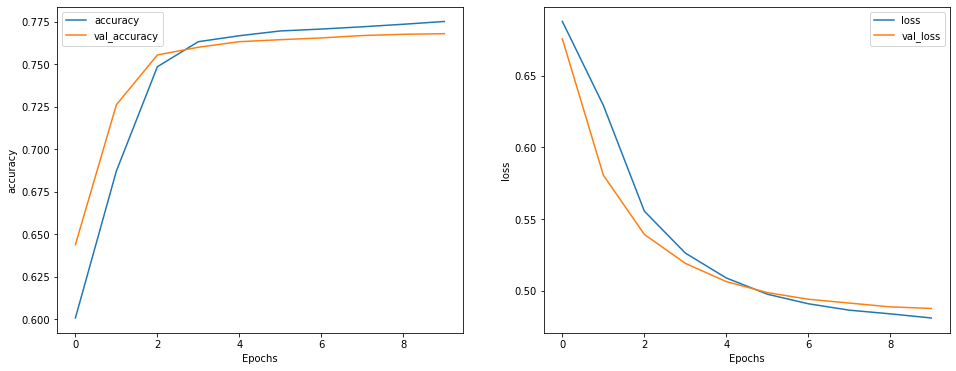

In [43]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')

#### Testing

In [41]:
#testing
test_loss, test_acc = model2.evaluate(test_df.text,test_df.target)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1500/1500 [==============================] - 40s 20ms/step - loss: 0.4898 - accuracy: 0.7648
Test Loss: 0.4898202419281006
Test Accuracy: 0.7648333311080933


#### Metrics

In [44]:
#Prediction
pred2 = model2.predict(test_df.text)
pred2

array([[0.4670565 ],
       [0.76753676],
       [0.08926216],
       ...,
       [0.96273583],
       [0.19381869],
       [0.8583961 ]], dtype=float32)

Legitimate Transactions Detected (True Negatives):  18358 76.19324313106998 %
Legitimate Transactions Incorrectly Detected (False Positives):  5552
Fraudulent Transactions Missed (False Negatives):  5736
Fraudulent Transactions Detected (True Positives):  18354 76.77570484397222 %
Total Fraudulent Transactions:  24090


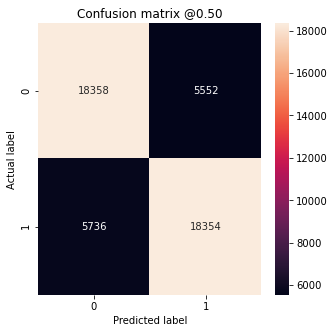

In [45]:
#Metrics
plot_cm(test_df.target, pred2)

**Model 2 conclusions:**
- The Loss Function plot behavior is very good, because the training and validation curves are descending in both cases
- Around epoch number 5, validation accuracy is less than training accuracy
- Testing accuracy is better than accuracy in Model 1

### 4.3 Model 1 with grid search

In [46]:
def make_model( dense_units = 64
               , dropout = 0.5
               , lr = 1e-4
               , verbose = 1):
    

    model = Sequential()

    #Pre-processing
    #encoder: prepare the input 
    model.add(encoder)
    #embedding: Turns positive integers (indexes) into dense vectors of fixed size.
    model.add(layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True))

    #Corpus
    #Bidirectional layer: This propagates the input forward and backwards through the RNN layer and then concatenates the final output.
    model.add(layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)))
    model.add(layers.Bidirectional(tf.keras.layers.LSTM(32)))
    # Dense layer: Densely-connected NN layer
    model.add(layers.Dense(dense_units, activation='relu'))
    #Applies Dropout for regularization
    model.add(layers.Dropout(dropout))

    #Final layer: a single output from binary target
    model.add(layers.Dense(1, activation='sigmoid'))
    
    #compile: Configures the model for training
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), #BinaryCrossentropy: binary target
                  optimizer=tf.keras.optimizers.Adam(lr),
                  metrics=['accuracy'])
    model.summary()

    return model

In [47]:
#list to perform the grid search
dense_units = [32,64]
dropout = [0.2, 0.5]
lr = [1e-4,1e-3]


import itertools

param_grid = dict(dense_units = dense_units
                  , dropout = dropout
                  , lr=lr
                 )
param_grid.keys()

dict_keys(['dense_units', 'dropout', 'lr'])

In [48]:
#Model Definition
model3 = make_model( dense_units = 10
                    ,dropout = 0.5
                    ,lr = 1e-3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 10)                650       
                                                      

#### dense_units
Tuning the number of nodes in layer before the last one

In [49]:
#list to perform the grid search
dense_units = [16,32,64]
dropout = [0.5]
lr = [1e-4]


import itertools

param_grid = dict(dense_units = dense_units
                  , dropout = dropout
                  , lr=lr
                 )
param_grid.keys()

dict_keys(['dense_units', 'dropout', 'lr'])

In [50]:
#iteration 
keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    dense_units = param_grid[j].get("dense_units")
    dropout = param_grid[j].get("dropout")
    lr = param_grid[j].get("lr")

    model3 = make_model( dense_units = dense_units
                       , dropout = dropout
                       , lr = lr)
    
    history3 = model3.fit(x=train_df.text, y=train_df.target
                         ,epochs=10
                         ,batch_size=1000
                         ,validation_data=(val_df.text,val_df.target)
                         ,validation_steps=30)
    
    accuracy = pd.DataFrame.from_dict(history3.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"accuracy":accuracy})
    
results = pd.DataFrame(param_grid)

Proposed 3 models
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 128)        66048     
 nal)                                                            
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                    

In [51]:
#grid search results
results.sort_values(['accuracy'],ascending = False)

,dense_units,dropout,lr,accuracy
2,64,0.5,0.0001,0.774043
0,16,0.5,0.0001,0.773597
1,32,0.5,0.0001,0.773329


**Conclusions:**
- When we tunning the number of nodes, the accuracy is not changing too much
- If we check the loss function in all models, at the end, val_loss(validation) is not very different from the training loss

#### dropout
Tuning the dropout percent for the regularization

In [52]:
#list to perform the grid search
dense_units = [32]
dropout = [0.1, 0.3, 0.5]
lr = [1e-3]


import itertools

param_grid = dict(dense_units = dense_units
                  , dropout = dropout
                  , lr=lr
                 )
param_grid.keys()

dict_keys(['dense_units', 'dropout', 'lr'])

In [53]:
#iteration 
keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    dense_units = param_grid[j].get("dense_units")
    dropout = param_grid[j].get("dropout")
    lr = param_grid[j].get("lr")
    
    #make model
    model4 = make_model( dense_units = dense_units
                       , dropout = dropout
                       , lr = lr)
    
    #history
    history4 = model4.fit(x=train_df.text, y=train_df.target
                         ,epochs=10
                         ,batch_size=1000
                         ,validation_data=(val_df.text,val_df.target)
                         ,validation_steps=30)
    
    accuracy = pd.DataFrame.from_dict(history4.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"accuracy":accuracy})
    
results = pd.DataFrame(param_grid)

Proposed 3 models
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_11 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_12 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                    

In [54]:
#grid search results
results.sort_values(['accuracy'],ascending = False)

,dense_units,dropout,lr,accuracy
1,32,0.3,0.001,0.788839
0,32,0.1,0.001,0.786926
2,32,0.5,0.001,0.785906


**Conclusions:**
- When we tunning the number of nodes, the accuracy is not changing too much
- If we check the accuracy in all models, at the end, val_accuracy(validation) is not very different from the accuracy in traning

#### learning rate
Tuning the argument of the optimization 

In [55]:
#list to perform the grid search
dense_units = [32]
dropout = [0.5]
lr = [1e-1, 1e-2, 1e-3]


import itertools

param_grid = dict(dense_units = dense_units
                  , dropout = dropout
                  , lr=lr
                 )
param_grid.keys()

dict_keys(['dense_units', 'dropout', 'lr'])

In [56]:
#iteration 
keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    dense_units = param_grid[j].get("dense_units")
    dropout = param_grid[j].get("dropout")
    lr = param_grid[j].get("lr")
    
    #make model
    model5 = make_model( dense_units = dense_units
                       , dropout = dropout
                       , lr = lr)
    
    #history
    history5 = model5.fit(x=train_df.text, y=train_df.target
                         ,epochs=10
                         ,batch_size=1000
                         ,validation_data=(val_df.text,val_df.target)
                         ,validation_steps=30)
    
    accuracy = pd.DataFrame.from_dict(history5.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"accuracy":accuracy})
    
results = pd.DataFrame(param_grid)

Proposed 3 models
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_9 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_17 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_18 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                   

In [57]:
#grid search results
results.sort_values(['accuracy'],ascending = False)

,dense_units,dropout,lr,accuracy
1,32,0.5,0.010,0.836084
2,32,0.5,0.001,0.784643
0,32,0.5,0.100,0.726059


**Conclusions:**
- The better result is when learning rate is 0.010
- If we check the loss function in all models, at the end, val_loss(validation) is not very different from the training loss

#### Combination grid search
Tuning different arguments at the same time

In [58]:
#list to perform the grid search
dense_units = [32, 64]
dropout = [0.5]
lr = [1e-1, 1e-3]


import itertools

param_grid = dict(dense_units = dense_units
                  , dropout = dropout
                  , lr=lr
                 )
param_grid.keys()

dict_keys(['dense_units', 'dropout', 'lr'])

In [59]:
#iteration 
keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    dense_units = param_grid[j].get("dense_units")
    dropout = param_grid[j].get("dropout")
    lr = param_grid[j].get("lr")
    
    #make model
    model6 = make_model( dense_units = dense_units
                       , dropout = dropout
                       , lr = lr)
    
    #history
    history6 = model6.fit(x=train_df.text, y=train_df.target
                         ,epochs=10
                         ,batch_size=1000
                         ,validation_data=(val_df.text,val_df.target)
                         ,validation_steps=30)
    
    accuracy = pd.DataFrame.from_dict(history6.history)['accuracy'].iloc[-1]
    param_grid[j].update( {"accuracy":accuracy})
    
results = pd.DataFrame(param_grid)

Proposed 4 models
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_12 (Embedding)    (None, None, 64)          64000     
                                                                 
 bidirectional_23 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_24 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                   

In [60]:
#grid search results
results.sort_values(['accuracy'],ascending = False)

,dense_units,dropout,lr,accuracy
3,64,0.5,0.001,0.788992
1,32,0.5,0.001,0.786901
0,32,0.5,0.100,0.740689
2,64,0.5,0.100,0.715523


**Grid search conclusions:**
Comparing all this results, the higher accuracy is the model with this parameters:
 - dense_units: 32
 - dropout: 0.5
 - learning_rate: 0.010

## 5. Feature engineering
### 5.1 Data cleaning

In [61]:
#emojis list
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip',
          '=^.^=': 'cat', ':D': 'smile', ';D': 'smile'}

In [62]:
mystopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [67]:
# Natural Language Toolkit (nltk)
from nltk.stem import WordNetLemmatizer
from nltk import download
download('stopwords')
download('wordnet')
from nltk.corpus import stopwords
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\auxis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\auxis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [64]:
english_stop_words =  stopwords.words('english')
english_stop_words[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [65]:
#Clean data function
def preprocess(textdata):
    processedText = []
    
    #creating a Lemmatizer
    wordLemma = WordNetLemmatizer() #define the imported library
    
    # Defining regular expression pattern we can find. in tweets
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" # e.g check out https://dot.com for more
    userPattern       = '@[^\s]+' # e.g @FagbamigbeK check this out
    alphaPattern      = "[^a-zA-Z0-9]" # e.g I am *10 better!
    sequencePattern   = r"(.)\1\1+"  # e.g Heyyyyyyy, I am back!
    seqReplacePattern = r"\1\1" # e.g Replace Heyyyyyyy with Heyy
    
    
    for tweet in textdata:
        tweet = tweet.lower() #normalizing all text to a lower case
        
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet) #using the substitution method of the regular expression library
        
        
        # Replace all emojis.
        for emoji in emojis.keys(): #in each of the looped tweet, replace each emojis with their respective meaning
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])  # emojis[emoji] helps to get the value of the emoji from the dictionary
            
            
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)  #To hide Personal Information, we can replace all usernames with User
        
        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet) # e.g I am *10 better!
        
        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet) # e.g Replace Heyyyyyyy with Heyy
        
        
        tweetwords = ''
        for word in tweet.split():
            if len(word) > 2 and word.isalpha():
                word = wordLemma.lemmatize(word)
                tweetwords += (word + ' ')
        
        processedText.append(tweetwords)
        
    return processedText

In [68]:
#Data transformation: example
data2 = dataframe.copy()
data2['target'] = data2.target.replace(4,1)
data2['text'] = preprocess(data2.text)
data2.head()

,target,text
514293,0,miss nikki already shes always there when need...
142282,0,had dream last night remember sign which clear...
403727,0,USER ohh poor sickly you hug hope you feel lit...
649503,0,raining again
610789,0,USER wish wa right now


In [69]:
#Transform X - features
X_train_clean = np.array(preprocess(X_train))
print(X_train_clean[0:10])
X_val_clean = np.array(preprocess(X_val))
print(X_val_clean[0:10])
X_test_clean = np.array(preprocess(X_test))
print(X_test_clean[0:10])

['gotta parent the rudest ppl ever '
 'USER hey you are you still anyway did you get reply one particular '
 'USER thanks much '
 'last chemistry lesson for this school year brighter note birthday will sandwiched between two day chemistry lab '
 'headache '
 'USER not even better than kapsel cha nulis note spertinya ditag cuz ada notificationnya huhu '
 'USER thanks '
 'but think this movie boring opinon bullshit ehhm yay finished second chapter for wandern ist de sportlers lust '
 'hate hayfever eye are leaking nose running and keep sneezing not doing well '
 'upset take good care please ']
['umm who invented profanity why bitch curse word did they say curse word when jesus walked the earth being serious here '
 'USER not yet need more traffic the old blog methinks how about fotomoto '
 'bored the condo nobody home '
 'USER voted for you demi say goo lucking tomorrow have the exam school and talk about you subject music '
 'USER come think all award were for scam hiks wasn fault hiks 

In [70]:
#Transform y - target
y_train_clean = np.array(y_train)
print(y_train_clean[0:10])

y_val_clean = np.array(y_val)
print(y_val_clean[0:10])

y_test_clean = np.array(y_test)
print(y_test_clean[0:10])

[0 1 1 1 0 0 1 1 0 0]
[1 0 0 1 0 0 1 0 1 1]
[0 0 0 0 1 1 1 1 1 1]


### 5.2 Model 3 
Appply the best model hyperparameters 

#### Model

In [71]:
#Define the model
model_final = make_model( dense_units = 32
               , dropout = 0.5
               , lr = 0.010
               , verbose = 1)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_16 (Embedding)    (None, None, 64)          64000     
                                                                 
 bidirectional_31 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_32 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                     

#### Training

In [72]:
#Fit the model
history_final = model_final.fit(x=X_train_clean, y=y_train_clean
                         ,epochs=10
                         ,batch_size=1000
                         ,validation_data=(X_val_clean,y_val_clean)
                         ,validation_steps=30)

accuracy = pd.DataFrame.from_dict(history_final.history)['accuracy'].iloc[-1]

Epoch 1/10
79/79 [==============================] - 585s 7s/step - loss: 0.5422 - accuracy: 0.7250 - val_loss: 0.5014 - val_accuracy: 0.7546
Epoch 2/10
79/79 [==============================] - 513s 6s/step - loss: 0.4976 - accuracy: 0.7591 - val_loss: 0.4900 - val_accuracy: 0.7590
Epoch 3/10
79/79 [==============================] - 461s 6s/step - loss: 0.4824 - accuracy: 0.7660 - val_loss: 0.4893 - val_accuracy: 0.7645
Epoch 4/10
79/79 [==============================] - 444s 6s/step - loss: 0.4708 - accuracy: 0.7734 - val_loss: 0.4857 - val_accuracy: 0.7628
Epoch 5/10
79/79 [==============================] - 457s 6s/step - loss: 0.4619 - accuracy: 0.7791 - val_loss: 0.4875 - val_accuracy: 0.7604
Epoch 6/10
79/79 [==============================] - 456s 6s/step - loss: 0.4521 - accuracy: 0.7839 - val_loss: 0.4974 - val_accuracy: 0.7617
Epoch 7/10
79/79 [==============================] - 453s 6s/step - loss: 0.4404 - accuracy: 0.7897 - val_loss: 0.4989 - val_accuracy: 0.7567
Epoch 8/10
79

(0.0, 1.0)

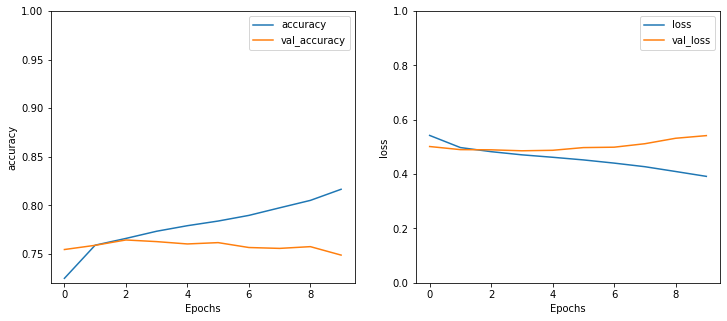

In [75]:
#Check the evolution in accuracy and loss around the epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_graphs(history_final, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history_final, 'loss')
plt.ylim(0, 1)

In [73]:
#Training accuracy
accuracy 

0.8166071176528931

**Conclusions:**
- Loss function in training and validation are not very similiar at the end, so the model is overfitting
- Accuracy gets worse with the validation set, but better in training, the model is overfitting

#### Testing

In [74]:
#testing
test_loss, test_acc = model_final.evaluate(X_test_clean,y_test_clean)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

1500/1500 [==============================] - 131s 82ms/step - loss: 0.5449 - accuracy: 0.7484
Test Loss: 0.5449116230010986
Test Accuracy: 0.7484166622161865


In [76]:
#Prediction
pred1 = model_final.predict(X_test_clean)
pred1

array([[0.39919156],
       [0.2445023 ],
       [0.02264413],
       ...,
       [0.96122396],
       [0.04419217],
       [0.42691177]], dtype=float32)

Legitimate Transactions Detected (True Negatives):  18061 74.36182476943345 %
Legitimate Transactions Incorrectly Detected (False Positives):  5849
Fraudulent Transactions Missed (False Negatives):  6227
Fraudulent Transactions Detected (True Positives):  17863 75.33316464237517 %
Total Fraudulent Transactions:  24090


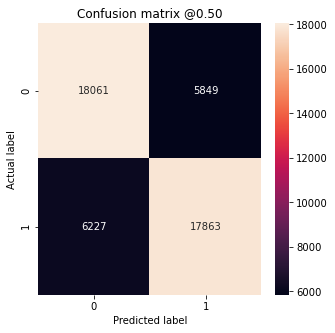

In [77]:
#Metrics
plot_cm(test_df.target, pred1)

**Conclusion:**

This model is overfitting. Some evidences:
 - Accuracy: The training accuracy is greater than validation accuracy, and even testing accuracy is lower
 - In Loss Function plot, training curve and validation curve are separating with grater epochs
 - In Accuracy plot, training curve and validation curve are separating with grater epochs